# Filtering tiles
We can reduce the compute time and prevent many false-positive errors by restricting the analysis to the tiles that are likely to contain sea ice. 

1. Analysis of the validation dataset
2. Examples with large images.

In [49]:
using Pkg
Pkg.activate("calval")
using IceFloeTracker
using Images
using CSV
# include("../scripts/dev/validation_data.jl")

  Activating project at `~/Documents/research/manuscripts/cal-val_ice_floe_tracker/calval_tgrs/notebooks/calval`


In [50]:
Pkg.add("Plots")
using Plots

   Resolving package versions...
  No Changes to `~/Documents/research/manuscripts/cal-val_ice_floe_tracker/calval_tgrs/notebooks/calval/Project.toml`
  No Changes to `~/Documents/research/manuscripts/cal-val_ice_floe_tracker/calval_tgrs/notebooks/calval/Manifest.toml`


In [13]:
data_loader = Watkins2025GitHub(; ref="a451cd5e62a10309a9640fbbe6b32a236fcebc70")
dataset = data_loader(c -> c.case_number == 31 && c.satellite == "aqua");

┌ Warning: In /tmp/Watkins2025/a451cd5e62a10309a9640fbbe6b32a236fcebc70/validation_dataset.csv line 381 has 0 fields but 28 fields are expected. Skipping row.
└ @ TextParse ~/.julia/packages/TextParse/bX5Ws/src/csv.jl:390


In [15]:
case = first(dataset)
landmask = Gray.(case.modis_landmask) .> 0
tc_img .* .! landmask

LoadError: UndefVarError: `tc_img` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [51]:
"""Compute the fraction of non-ocean pixels covered by cloud"""
function ocean_cloud_fraction(cloudfrac, landmask)
    lm = vec(landmask)
    cf = vec(cloudfrac)[.!lm]
    length(cf) > 0 ? (return round(mean(cf), digits=3)) : (return NaN)
end

"""Compute the contrast by differencing the 99th and 1st percentile"""
function robust_contrast(img_band, landmask; min_pct=1, max_pct=99)
    lm = vec(landmask)
    band_data = vec(img_band)[.!lm]
    length(band_data) > 0 ? (return round(percentile(band_data, max_pct) - percentile(band_data, min_pct), digits=3)) : (return 0)
end

"""Compute the fraction of non-cloudy ocean pixels with band 2 brightness above a given threshold"""
function possible_clear_sky_sea_ice(band_2, landmask, cloudmask; possible_ice_threshold=75/255)
    ocean_nocloud = vec(.! (landmask .| cloudmask))
    b2 = vec(band_2)[ocean_nocloud]
    length(b2) > 0 ? (return round(mean(b2 .> possible_ice_threshold), digits=3)) : (return 0)
end

possible_clear_sky_sea_ice

In [100]:
using Statistics 
using StatsBase

function get_image_stats(tc_image, fc_image, cloud_mask, land_mask, tile_markers, tiles)
    df = DataFrame(
                   tile_index=Int16[],
                   ground_truth=[],
                   cloud_fraction=Float64[],                   
                   land_fraction=Float64[],
                   truecolor_band_1_contrast=Float64[],
                   falsecolor_band_2_contrast=Float64[],
                   falsecolor_band_7_contrast=Float64[],
                   truecolor_band_1_entropy=Float64[],
                   falsecolor_band_2_entropy=Float64[],
                   falsecolor_band_7_entropy=Float64[],
                   possible_sea_ice_fraction=Float64[]
                   )
    
    for (index, tile) in enumerate(tiles)
        push!(df, (
                   tile_index = index,
                   ground_truth = maximum(tile_markers[tile...]) > 0,
                   cloud_fraction = ocean_cloud_fraction(cloud_mask[tile...], land_mask[tile...]),
                   land_fraction = mean(land_mask[tile...]),
                   truecolor_band_1_contrast = robust_contrast(red.(tc_image[tile...]), land_mask[tile...]),
                   falsecolor_band_2_contrast = robust_contrast(green.(fc_image[tile...]), land_mask[tile...]),
                   falsecolor_band_7_contrast = robust_contrast(red.(fc_image[tile...]), land_mask[tile...]),
                   truecolor_band_1_entropy = Images.entropy(red.(tc_image[tile...]) .* .! land_mask[tile...]), 
                   falsecolor_band_2_entropy = Images.entropy(green.(fc_image[tile...]) .* .! land_mask[tile...]),
                   falsecolor_band_7_entropy = Images.entropy(red.(fc_image[tile...]) .* .! land_mask[tile...]),
                   possible_sea_ice_fraction = possible_clear_sky_sea_ice(
                                                    green.(fc_image[tile...]),
                                                    land_mask[tile...],
                                                    cloud_mask[tile...]))
                )
    end
    return df
end

get_image_stats (generic function with 2 methods)

In [101]:
cloud_mask_settings = (
    prelim_threshold=53.0/255.,
    band_7_threshold=130.0/255.,
    band_2_threshold=169.0/255.,
    ratio_lower=0.0,
    ratio_offset=0.0,
    ratio_upper=0.53
)

cmask = LopezAcostaCloudMask(cloud_mask_settings...)
dataloc = "../data/validation_dataset/modis_500km"
tc_filenames = filter(x -> !occursin(".DS", x), readdir(joinpath(dataloc, "truecolor")))

for tc_filename in tc_filenames

    fc_filename = replace(tc_filename, "truecolor" => "falsecolor")
    markers_filename = replace(replace(tc_filename, "truecolor" => "markers"), "tiff" => "png")
    landmask_filename = occursin("aqua", tc_filename) ? replace(tc_filename, "aqua-" => "") : replace(tc_filename, "terra-" => "")
    landmask_filename = replace(landmask_filename, "truecolor" => "landmask")



    landmask_filename = occursin("aqua", tc_filename) ? replace(tc_filename, "aqua-" => "") : replace(tc_filename, "terra-" => "")
    landmask_filename = replace(landmask_filename, "truecolor" => "landmask")
    
    tc_image = RGB.(load(joinpath(dataloc, "truecolor", tc_filename)))
    fc_image = RGB.(load(joinpath(dataloc, "falsecolor", replace(tc_filename, "truecolor" => "falsecolor"))))
    tile_markers = Gray.(load(joinpath(dataloc, "tile_markers", markers_filename))) .> 0
    land_image = Gray.(load(joinpath(dataloc, "landmask", landmask_filename)))
    
    cloud_mask = IceFloeTracker.create_cloudmask(fc_image, cmask)
    land_mask = land_image .> 0.1
    
    # with 256 m pixels instead of our usual 250 m tiles, we have approx 98 pixels per 25 km.
    tiles = IceFloeTracker.get_tiles(tc_image, 98)
    
    # use the markers to make a checkerboard
    for tile in filter(t -> maximum(tile_markers[t...]) .> 0, tiles)
        tile_markers[tile...] .= 1
    end

    df = get_image_stats(tc_image, fc_image, cloud_mask, land_mask, tile_markers, tiles)
    
    CSV.write(joinpath(dataloc, "25km_data_tables/", replace(tc_filename, "truecolor.tiff" => "statistics.csv")), df)
end

In [107]:
tc_filenames

18-element Vector{String}:
 "001-baffin_bay-500km-20220911-aqua-250m-truecolor.tiff"
 "001-baffin_bay-500km-20220911-terra-250m-truecolor.tiff"
 "022-barents_kara_seas-500km-20060909-aqua-250m-truecolor.tiff"
 "022-barents_kara_seas-500km-20060909-terra-250m-truecolor.tiff"
 "043-beaufort_sea-500km-20190813-aqua-250m-truecolor.tiff"
 "043-beaufort_sea-500km-20190813-terra-250m-truecolor.tiff"
 "065-bering_chukchi_seas-500km-20080507-aqua-250m-truecolor.tiff"
 "065-bering_chukchi_seas-500km-20080507-terra-250m-truecolor.tiff"
 "086-east_siberian_sea-500km-20060927-aqua-250m-truecolor.tiff"
 "086-east_siberian_sea-500km-20060927-terra-250m-truecolor.tiff"
 "106-greenland_sea-500km-20140911-aqua-250m-truecolor.tiff"
 "106-greenland_sea-500km-20140911-terra-250m-truecolor.tiff"
 "128-hudson_bay-500km-20190415-aqua-250m-truecolor.tiff"
 "128-hudson_bay-500km-20190415-terra-250m-truecolor.tiff"
 "148-laptev_sea-500km-20110324-aqua-250m-truecolor.tiff"
 "148-laptev_sea-500km-20110324-terra-25

In [104]:
tc_filename = "022-barents_kara_seas-500km-20060909-aqua-250m-truecolor.tiff"
fc_filename = replace(tc_filename, "truecolor" => "falsecolor")
markers_filename = replace(replace(tc_filename, "truecolor" => "markers"), "tiff" => "png")
landmask_filename = occursin("aqua", tc_filename) ? replace(tc_filename, "aqua-" => "") : replace(tc_filename, "terra-" => "")
landmask_filename = replace(landmask_filename, "truecolor" => "landmask")

landmask_filename = occursin("aqua", tc_filename) ? replace(tc_filename, "aqua-" => "") : replace(tc_filename, "terra-" => "")
landmask_filename = replace(landmask_filename, "truecolor" => "landmask")

tc_image = RGB.(load(joinpath(dataloc, "truecolor", tc_filename)))
fc_image = RGB.(load(joinpath(dataloc, "falsecolor", replace(tc_filename, "truecolor" => "falsecolor"))))
tile_markers = Gray.(load(joinpath(dataloc, "tile_markers", markers_filename))) .> 0
land_image = Gray.(load(joinpath(dataloc, "landmask", landmask_filename)));
cloud_mask = IceFloeTracker.create_cloudmask(fc_image, cmask)
land_mask = land_image .> 0.1

1953×1953 BitMatrix:
 0  0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     

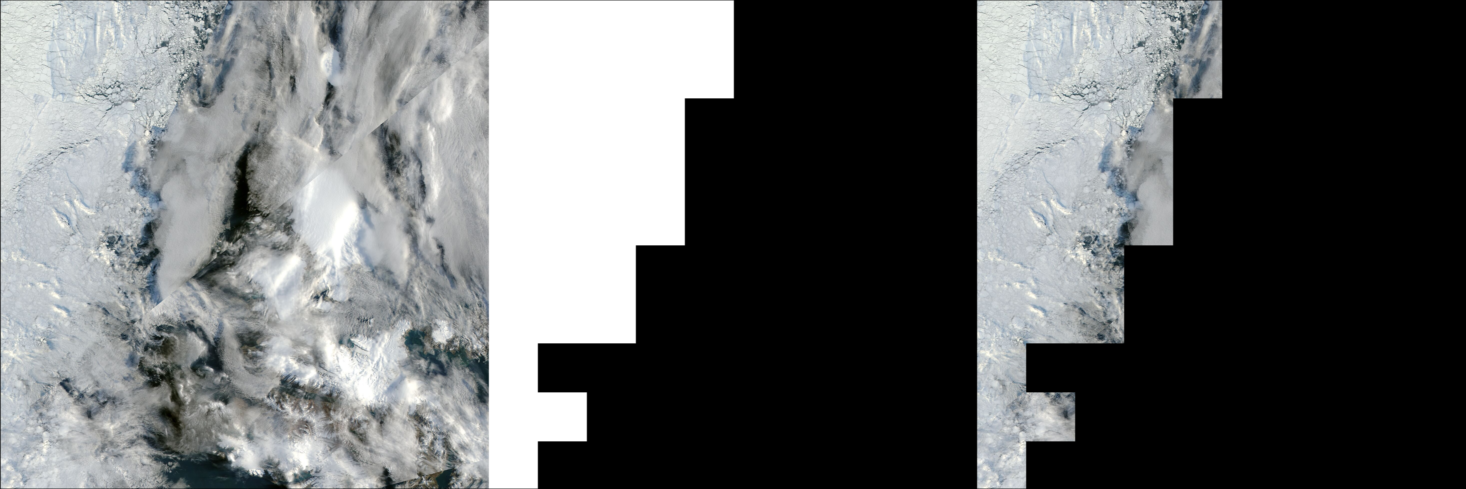

In [93]:
# We can also look at 50 km (or 100 km, or whichever) by selecting tiles containing markers
# using larger tile spacing.
tiles = IceFloeTracker.get_tiles(tc_image, 2*98)

# use the markers to make a checkerboard
for tile in filter(t -> maximum(tile_markers[t...]) .> 0, tiles)
    tile_markers[tile...] .= 1
end

mosaicview(tc_image, Gray.(tile_markers), tc_image .* tile_markers, nrow=1)

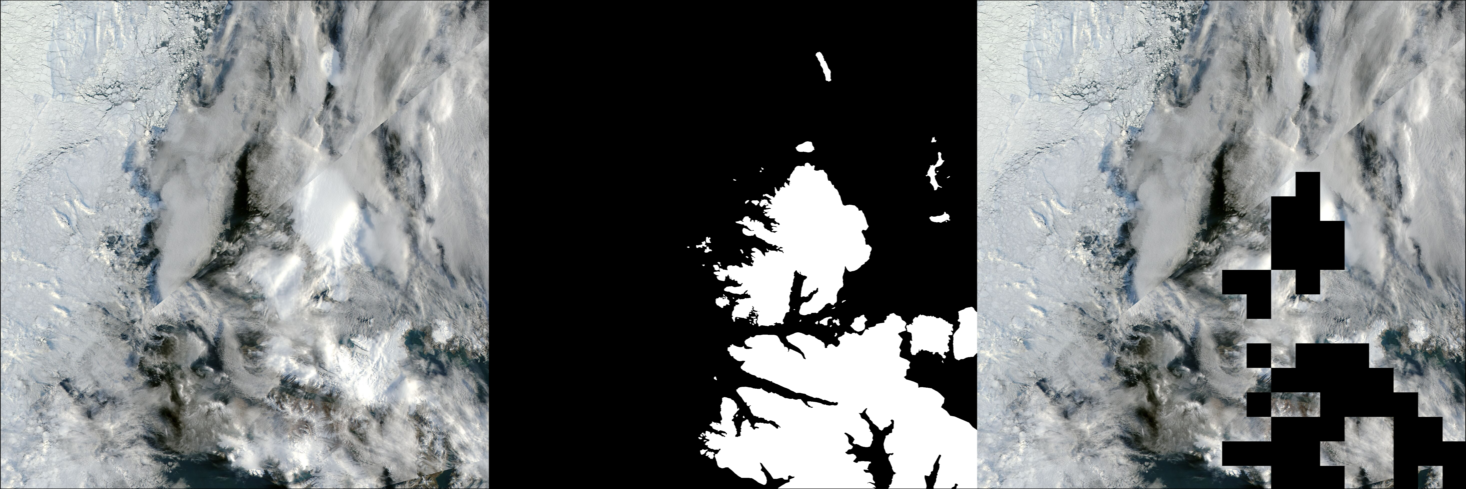

In [106]:
land_markers = zeros(size(tc_image))
for tile in filter(t -> mean(land_mask[t...]) .< 0.9, tiles)
    land_markers[tile...] .= 1
end
mosaicview(tc_image, Gray.(land_mask), tc_image .* land_markers, nrow=1)

# Next steps
The goal is to find a simple combination of these metrics to rule out portions of the image that have no detectable sea ice.
These regions are likely to be cloudy, open water, or just ice that we can't distinguish. I need to do a statistical test that determines which combination of metrics is the smallest useful set, and potentially do a regression on the variables to find the best predictor of a tile containing sea ice. Then, I need to see if it is size-dependent.

For this small number of terms, I can check which are mutually uncorrelated, then use logistic regression (or similar) to find a separation.

In [35]:
using Plots
cor(subset(df, :ground_truth)[:, :truecolor_band_1_contrast], subset(df, :ground_truth)[:, :falsecolor_band_2_contrast])

-0.012185847608072163

In [44]:
cor(subset(df, :ground_truth)[:, :truecolor_band_1_contrast], subset(df, :ground_truth)[:, :falsecolor_band_7_contrast])

0.272020475794354

In [45]:
cor(subset(df, :ground_truth)[:, :falsecolor_band_7_contrast], subset(df, :ground_truth)[:, :falsecolor_band_2_contrast])

0.5504635429172174

In [ ]:
histogram(subset(df, :ground_truth => ByRow(!))[:, :truecolor_band_1_contrast], bins=range(0, 1, 20))
histogram!(subset(df, :ground_truth)[:, :truecolor_band_1_contrast], bins=range(0, 1, 20))

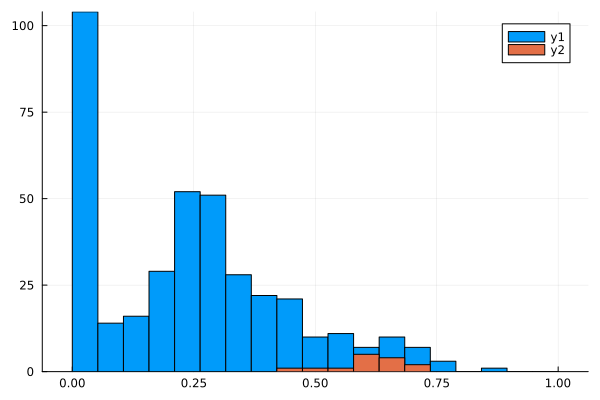

In [31]:

histogram(subset(df, :ground_truth => ByRow(!))[:, :truecolor_band_1_contrast], bins=range(0, 1, 20))
histogram!(subset(df, :ground_truth)[:, :truecolor_band_1_contrast], bins=range(0, 1, 20))

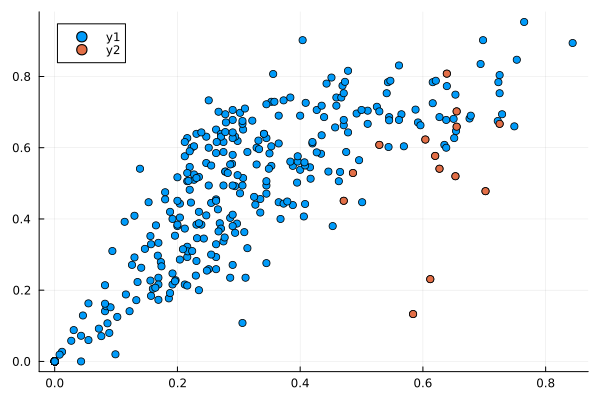

In [40]:
scatter(df[:, :truecolor_band_1_contrast], 
    df[:, :falsecolor_band_7_contrast])
scatter!(subset(df, :ground_truth)[:, :truecolor_band_1_contrast], 
    subset(df, :ground_truth)[:, :falsecolor_band_7_contrast])

In [27]:
using StatsBase
robust_contrast(red.(tc_img), landmask)
ocean_cloud_fraction(cloudmask, landmask)
possible_sea_ice(green.(fc_img), landmask, cloudmask)

0.021

In [1]:
using Pkg
Pkg.add("GLM")

   Resolving package versions...
   Installed ShiftedArrays ─ v2.0.0
   Installed StatsModels ─── v0.7.7
   Installed GLM ─────────── v1.9.0
   Installed FillArrays ──── v1.14.0
    Updating `~/.julia/environments/v1.11/Project.toml`
  [38e38edf] + GLM v1.9.0
    Updating `~/.julia/environments/v1.11/Manifest.toml`
  [31c24e10] + Distributions v0.25.120
  [1a297f60] + FillArrays v1.14.0
  [38e38edf] + GLM v1.9.0
  [34004b35] + HypergeometricFunctions v0.3.28
  [90014a1f] + PDMats v0.11.35
  [1fd47b50] + QuadGK v2.11.2
  [79098fc4] + Rmath v0.8.0
  [1277b4bf] + ShiftedArrays v2.0.0
  [4c63d2b9] + StatsFuns v1.5.0
  [3eaba693] + StatsModels v0.7.7
  [f50d1b31] + Rmath_jll v0.5.1+0
  [4607b0f0] + SuiteSparse
Precompiling project...
    692.3 ms  ✓ ShiftedArrays
    937.8 ms  ✓ FillArrays
    538.5 ms  ✓ FillArrays → FillArraysStatisticsExt
    502.0 ms  ✓ FillArrays → FillArraysSparseArraysExt
    612.8 ms  ✓ FillArrays → FillArraysPDMatsExt
   1547.4 ms  ✓ StatsModels
   3373.9 ms  ✓ Dis

In [76]:
# grid for the large images
# Image is 1953 by 1953 pixels (pixel is 256 m)
# Other images from project are 250 m / pixel.



In [68]:
1953/98

19.928571428571427